## NN Adv Assignment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [2]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

train = dsets.FashionMNIST(root='./data', 
                          train=True, 
                          transform=transforms.ToTensor(), 
                          download=True)

test = dsets.FashionMNIST(root='./data', 
                         train=False, 
                         transform=transforms.ToTensor(),
                         download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [ ]:
train['label'].nunique()

10

In [ ]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,67,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,2,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,93,58,78,45,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,71,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,63,0,0,0,0,0,0,0


In [ ]:
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values

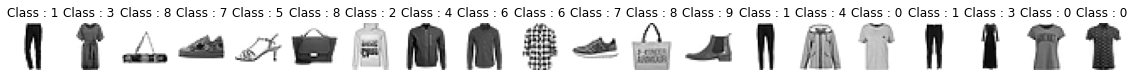

In [ ]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [ ]:
X_test = test.values

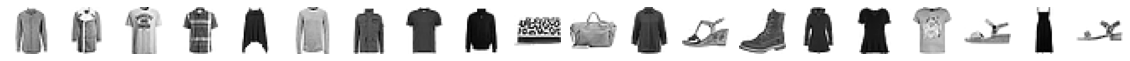

In [ ]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

### Normalization

In [ ]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

### Data loader

In [3]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [4]:
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

### CNN

In [5]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [6]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cuda


In [7]:
# Define Model
model = CNN().to(DEVICE)

### Compling Model

In [8]:
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 600


### Training Model

In [10]:
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.505875289
[Epoch:    2] cost = 0.308929771
[Epoch:    3] cost = 0.261089563
[Epoch:    4] cost = 0.228249148
[Epoch:    5] cost = 0.207173467
[Epoch:    6] cost = 0.185588226
[Epoch:    7] cost = 0.168057397
[Epoch:    8] cost = 0.15247348
[Epoch:    9] cost = 0.133913979
[Epoch:   10] cost = 0.125629127
[Epoch:   11] cost = 0.112275362
[Epoch:   12] cost = 0.0998229161
[Epoch:   13] cost = 0.0898813978
[Epoch:   14] cost = 0.0791336447
[Epoch:   15] cost = 0.0687345415


### Evaluate Model

In [12]:
with torch.no_grad():
    X_test = test.test_data.view(len(test), 1, 28, 28).float().to(DEVICE)
    Y_test = test.test_labels.to(DEVICE)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.7945999503135681
